# Problem Set 5 - Neural Networks
## CSCI 4622 - Spring 2023

***
**Name**: Kevin Stull
***

This assignment is due on Canvas by **11.59 PM on Wednesday, April 14th**.
Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.

Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
#!pip install -r requirements.txt #uncomment to install all required packages
import numpy as np
import matplotlib.pyplot as plt
import tests
import data
import sys

# Assignment Setup

For the first problem, we'll be using three synthetic datasets plotted below. From left to right: co-centric circles `circles`, blobs with 6 centers `multi_blobs`, and blobs with 2 centers `binary_blobs`.

Each of the dataset instances has (`X`, `labels`) attributes that are split into `train` and `test` partitions.
In the first problem, we'll implement our Multi-Layer Perceptron from scratch and test it on the `circles` dataset.

The second problem will focus on building your familiarity with TensorFlow package to build and customize a 2D Convolutional Neural Network based image classifier. This problem will use CIFAR10 dataset that contains 60,000 images with 10 classes. In this problem you will be building a simple 2D CNN based image classification network and hyperparameter tuning for the same.


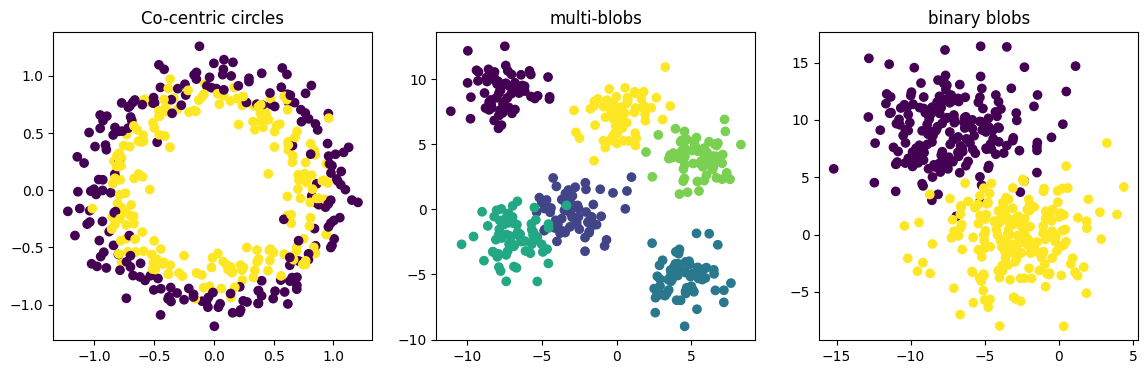

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
circles_offset = data.Circles(mode="-1/1")
multi_blobs = data.DataBlobs(centers=6, std=1.3)
binary_blobs = data.DataBlobs(centers=2, std=2.7)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4), fig.set_figwidth(14)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (multi_blobs, "multi-blobs"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()

# Problem 1: Neural Networks (50 points)


In the first problem, we'll be implementing our own Neural Networks framework and use it to build a Multi-Layer Perceptron.
The MLP is a sequence of linear projections and activation functions, each of which will be implemented as a layer.

Each layer will have its own parameters (none for the activations), a `forward` method that applies the transformation,
and a `backward` method that back-propagates the gradient and computes the parameters gradients.

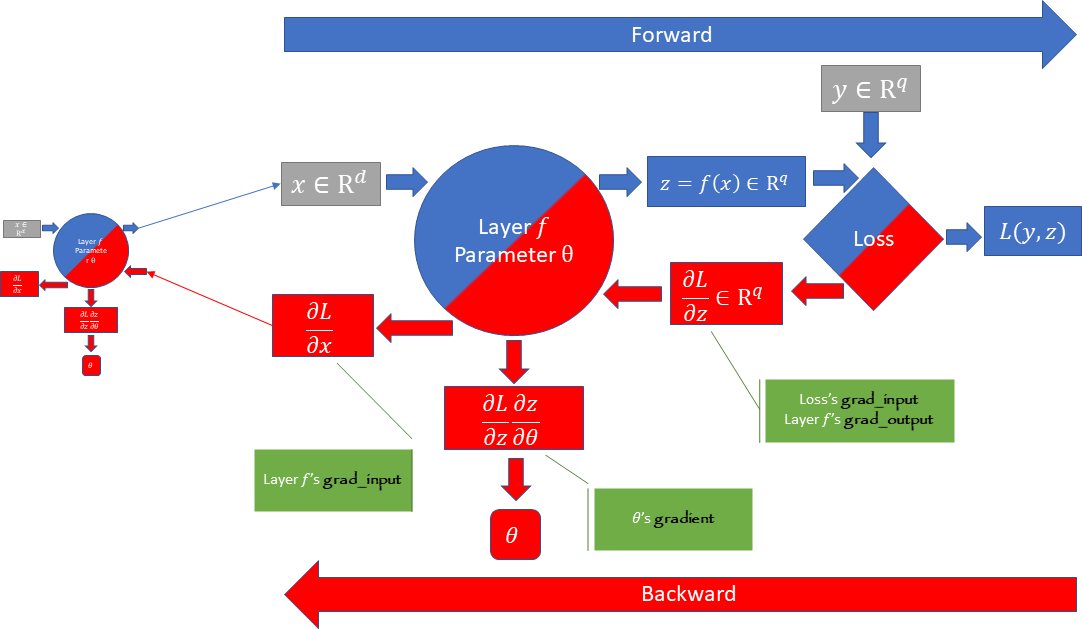
To understand how the mechanism works, let's consider the neural network that consists of one layer $f_\theta:  \mathbb{R}^d \mapsto \mathbb{R}^q$ where the parameter is optimized to minimize the loss $L$.

Our dataset consists of samples $(x_i)$ with $d$ features and a q-dimensional targets $(y_i)$. $f_\theta$ transforms  $(x_i)$ into $(z_i)$. We'll be using the Mean Squared Error (MSE) for the loss function $L$.

The neural network will have two passes:
 - forward pass where we transform the input into output,
 - and backward pass where we backpropagates the gradient and compute the gradient of the loss w.r.t to parameters.
 
Note that the gradient computation might require saving the input data from the forward pass since we won't be providing any data during the backward pass. We'll deal with that later.

Now, let's start from the layer $f_\theta: \mathbb{R}^d \mapsto \mathbb{R}^q$, with parameter $\theta$.

In order to compute the gradient for $\theta$, we first need the derivative of the loss w.r.t the layer's output $\frac{\partial L}{\partial z}$

We'll only deal with MSE loss defined as:
\begin{align}
MSE(y, z) = \frac{1}{m} \sum_{i=1}^{m} ||f_\psi(x_i) - y_i ||^2
\end{align}
, where $m$ is the sample size and $z_i = f_\theta(x_i)$.

The gradient of the loss w.r.t to its input $z$:

\begin{align}
 \frac{\partial MSE(y, z)}{\partial z}  = \frac{2}{m} (z - y)
\end{align}

- **1.1 [3 points]** Complete `MSE`'s `forward` method that returns the MSE between `y_pred` and `y_true`
- **1.2 [4 points]** Complete `MSE`'s `backward` method that returns the derivative w.r.t to the input `z`.

_Hint_: Notice that no argument is provided for the loss backward pass. You'll have to cache `y_pred` and `y_true` into your object-level `saved_arrays` variable during the `forward` call

In [3]:
class MSE:
    saved_arrays = []

    def forward(self, y_pred, y_true):
        """
        Compute the MSE loss
        @param y_pred: shape (m,q)
        @param y_true: shape (m,q)
        @return: scalar
        """
        # Workspace 1.1
        mse = 0
        #BEGIN
        
        # ChatGPT
        m = y_pred.shape[0]
        q = y_pred.shape[1]
        
        for i in range(m):
            for j in range(q):
                mse += (y_pred[i][j] - y_true[i][j]) ** 2
        

        # chatGPT tried to do it all at once, this does it by layer 
        mse /= m
        
        # Cache the necessary quantities for the backward pass
        self.saved_arrays = (y_pred, y_true)
        
        #END
        return mse

    def backward(self):
        """
        Compute the gradient w.r.t to the prediction y_pred
        You'll have to cache the necessary quantities into your object-level 
            `saved_arrays` variable during the forward pass
        @return: shape (m,q)
        """
        # Workspace 1.2
        grad_input = None
        #BEGIN
        
        # Get the cached arrays
        y_pred, y_true = self.saved_arrays
        
        # Compute the gradient w.r.t. y_pred
        m = y_pred.shape[0]

        # same change here 
        grad_input = (2 / m) * (y_pred - y_true)
        
        #END
        return grad_input


In [4]:
# Testing MSE
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
expected_mse = 0.17090547876852463
expected_grad = np.array([[-0.24193655, 0.04041597], [0.46728084, -0.25158067]])
mse = MSE()

assert np.isclose(mse.forward(mock_X, mock_X / 2), expected_mse)
assert np.alltrue(np.isclose(mse.backward(), expected_grad))


Now that we have the `grad_input` of `MSE`,  it's going to be `grad_output` from the perspective of the layer $f_\theta$.
- `grad_output` of layer $f_\theta$ is the derivative of the loss w.r.t to the layer's output (which is the next layer's input)
- `grad_input` of layer $f_\theta$ is the derivative of the loss w.r.t the layer's input

The `forward` method of a layer applies the transformation and keeps track of any relevant quantity for the gradient backpropagation.

The `backward` method is expected to return the gradient of the loss w.r.t to the layer's input using the chain rule.

In our implementation, we want to compute in each layer $f_\theta$:
- $\frac{\partial L }{\partial \theta} = \frac{\partial L }{\partial z} \frac{\partial z }{\partial \theta}$ is the `parameter.gradient` (if any)
- $\frac{\partial L }{\partial x} = \frac{\partial L}{\partial z} \frac{\partial f_\theta(x)}{\partial x}$, the the `grad_input` of layer $f$ and return it

The backward pass consists of sequentially doing what we've just mentioned for $f_\theta$

1. get the initial `grad_output` from loss layer (top layer)
2. In reverse order:
    - pass current `grad_output` to the next layer's backward
    - inside the layer's backward: compute `grad_input` and `parameter.gradient` (if there are any parameters)
    - `grad_output` <- `grad_input`
    - repeat 2
3. Loop through the parameters and apply the gradient

We'll apply this to our first layers: `hyperbolic tangent` and `ReLU`.
We don't have to worry about `parameter.gradient` since they don't have any parameters.

- **1.3 [5 points]** Complete the Hyperbolic Tangent ("Hyperbolic") activation layer. `forward` method applies the activation and `backward` should use the
chain rule to compute `grad_input` of the layer. You'll need to save the activation values to use them in `backward` call, for that you should use `self.saved_arrays` to cache them.

- **1.4 [5 points]** In a similar way, complete the ReLU activation layer. Note that $\frac{\partial \text{ReLU}(x)}{\partial x} = 1_{x\geq 0}$.

In [5]:
import numpy as np


class Layer(object):
    """
    Template Layer that will be used to implement all other layers
    """

    def __init__(self, name=""):
        self.saved_arrays = []  # You might need them for the backward pass
        self.parameters = []
        self.name = name  # to identify the layer

    def forward(self, x):
        """
        In the forward pass we receive an array containing the input and return an array containing the output.
        You can cache arbitrary objects for use in the backward pass in self.saved_arrays
        @param x: input array of size (batch_size, d)
        @return: output array
        """
        pass

    def backward(self, grad_output):
        """
        In the backward pass we receive an array containing the gradient of the loss with respect to the output,
        and we need to compute the gradient of the loss with respect to the input and the gradient of the weights (default as 0)
        @param grad_output:
        @return: grad
        """
        pass

class Hyperbolic(Layer):

    def forward(self, x):
        """
        Apply the hyperbolic tangent function to x. Don't forget to clip x to the interval [-25.0, 25.]
         before applying the activation
        @param x: input array of shape (batch_size, q)
        @return: element-size hyperbolic tangent of shape (batch_size, q)
        """
        
        # Recall that hyperbolic_tangent(x) = (e^x - e^-x)/(e^x + e^-x)

        hyperbolic = np.zeros_like(x)
        # Workspace 1.3 a
        #BEGIN
    
        # clips our input
        x_clipped = np.clip(x, -25.0, 25.0)

        # applies tanh
        hyperbolic = np.tanh(x_clipped)

        # save for backward pass 
        self.x = x

        #END
        return hyperbolic
    
    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activations don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return: grad_input of shape (batch_size, q)
        """
        grad_parameters = 0
        grad_input = np.zeros_like(grad_output)
        # Workspace 1.3 b
        #BEGIN

        grad_input = grad_output * (1/np.cosh(self.x))**2

        return grad_input 

class ReLU(Layer):

    def forward(self, x):
        """
        Apply the ReLU function to x.
        @param x: input array of shape (batch_size, q)
        @return: element-size ReLU of shape (batch_size, q)
        """
        # Workspace 1.4.a
        #BEGIN

        # Save x for backward pass
        self.x = x  
        relu = np.maximum(0,x)

        #END
        return relu

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activations don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return:grad_input: of shape (batch_size, q)
        """
        grad_input = 0
        grad_parameters = 0
        # Workspace 1.4.b
        #BEGIN
        
        # Compute the gradient of the input with respect to the output
        grad_input = grad_output * np.maximum(self.x, 0)

        #chatGPT came up with this clever representaion using a boolean mask 
        grad_input = grad_output * (self.x > 0)

        #END
        return grad_input

In [6]:
# Hyperbolic Tangent Tests
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]]) # input 1
grad_output = np.array([[0.19960269, 0.20993069], [-0.85814751, -0.41418101]]) # input 2
hyp_x = np.array([[-0.44934008, 0.08065636], [0.73271362, -0.46459975]]) # output 1 
grad_hyp_x = np.array([[0.15930161, 0.208565], [-0.39743451, -0.32477883]]) # output 2
hyperbolic = Hyperbolic()

assert np.alltrue(np.isclose(hyperbolic.forward(mock_X), hyp_x)) # 1 
assert np.alltrue(np.isclose(hyperbolic.backward(grad_output), grad_hyp_x)) # 2

In [7]:
# ReLU Tests
relu_x = np.array([[-0., 0.08083195], [0.93456167, -0.]])
grad_relu_x = np.array([[0., 0.20993069], [-0.85814751, -0.]])
relu = ReLU()
assert np.alltrue(np.isclose(relu.forward(mock_X), relu_x))
assert np.alltrue(np.isclose(relu.backward(grad_output), grad_relu_x))

Now we'll move to the exciting part. We'll implement our own _dense_ (linear) layer that has two parameters $\theta=(w,b)$,
with $w$ being the weights array and $b$ the bias.
This layer $f_\theta$ projects a $d$ dimensional input into an $q$ dimensional space as follows:

\begin{align}
f_\theta(x) = xw + b
\end{align}

and its derivatives are:

\begin{align}
\frac{\partial f_\theta}{\partial x} &= w \\
\frac{\partial f_\theta}{\partial w} &= x^T \\
\frac{\partial f_\theta}{\partial b} &= 1_m
\end{align}

where $1_q$ is the ones vector with the same dimension as $b$


To help you keep track of the gradient, we will be wrapping the parameters numpy arrays using the `Parameter` class.
`Parameter` instances are an extension of numpy arrays, but they have additional:
 - attribute `gradient`: initialized with zeros and has the same shape as the array
 - method `zero_gradient`: resets the gradient values to zero
 - method `apply_gradient(grad)`: adds `grad` to the array
 - optional attribute `name`: This is going to be useful when implementing the bonus `Adam` optimizer

_Hint_: At this level, our implementation imitates Pytorch

In [8]:
class Parameter(np.ndarray):
    def __new__(cls, input_array, name=""):
        array = np.asarray(input_array).view(cls)
        array.gradient = np.zeros(array.shape)
        array.name = name
        return array

    def __array_finalize__(self, array):
        if array is None: return
        self.gradient = getattr(array, "gradient", None)
        self.name = getattr(array, "name", None)

    def zero_gradient(self):
        self.gradient = self.gradient * 0.0

    def apply_gradient(self, grad):
        self[:] = self[:] + grad[:]


In [9]:
# demo on how to use Parameter
w = Parameter(np.ones(3, ), name="W_0")
print("Initial w:", w, id(w))  # object memory identifier, same id = same object
print("Name of w:", w.name)
print("Initial gradient:", w.gradient)
w.gradient = np.array([0.1, 0.2, 0.3])
print("Gradient:", w.gradient)
w.apply_gradient(-0.2*w.gradient) # learning rate 0.2
w.zero_gradient()
print("Final w:", w, id(w))
print("Final gradient:", w.gradient)

Initial w: [1. 1. 1.] 1225421920584
Name of w: W_0
Initial gradient: [0. 0. 0.]
Gradient: [0.1 0.2 0.3]
Final w: [0.98 0.96 0.94] 1225421920584
Final gradient: [0. 0. 0.]


- **1.5 [6 points]** Complete the `Dense` layer

In [10]:
class Dense(Layer):

    def __init__(self, input_dimension, output_dimension, name=""):
        """
        Initialize the layer's parameters
        :param input_dimension: The dimension of the input data
        :param output_dimension: the dimension of the output
        :param name: optional, name to identify the layer
        """
        super().__init__(name)
        # Do not change the initialization method
        self.bias = Parameter(np.random.randn(1, output_dimension) / output_dimension ** 0.5)
        self.weights = Parameter(np.random.randn(input_dimension, output_dimension) /
                                 (output_dimension * input_dimension) ** 0.5)
        self.parameters = [self.bias, self.weights]

    def forward(self, x):
        """
        Apply the linear projection and save the necessary objects for the backward pass
        @param x of shape (m, input_dimension)
        @param z = xw + b of shape (m, output_dimension)
        """
        # output = 0
        # Workspace 1.5.a
        #BEGIN
        
        self.saved_for_backward = x, self.weights, self.bias
        output = x @ self.weights + self.bias

        #END
        return output

    def backward(self, grad_output):
        """
        Compute the gradients using the aforementioned formulas. Do not change the return signature
        Update the parameters gradient attribute directly
        @param grad_output: shape (m, output_dimension)
        @return: grad_input of shape (m, input_dimension)
        """
        self.weights.zero_gradient()
        self.bias.zero_gradient()
        # Workspace 1.5.b
        #BEGIN
        
        x, w, b = self.saved_for_backward
        grad_input = grad_output @ w.T
        grad_weights = x.T @ grad_output
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        self.weights.apply_gradient(grad_weights)
        self.bias.apply_gradient(grad_bias)
        

        #END
        return grad_input


In [11]:
# Dense layer test
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
np.random.seed(42)
dense = Dense(2, 2)
dense.forward(mock_X)
gradient_input = dense.backward(grad_output)
dense_x = np.array([[0.18506688, -0.47570709], [0.71279085, 0.67281937]])
grad_dense_x = np.array([[0.22450554, -0.04794509], [-0.59331118, 0.14895661]])
grad_dense_weights = np.array([[-0.89857414, -0.48865751], [0.44792093, 0.22536898]])
grad_dense_bias = np.array([[-0.65854482, -0.20425032]])
assert np.alltrue(np.isclose(dense_x, dense.forward(mock_X)))
assert np.alltrue(np.isclose(grad_dense_x, gradient_input))
assert np.alltrue(np.isclose(grad_dense_weights, dense.weights.gradient))
assert np.alltrue(np.isclose(grad_dense_bias, dense.bias.gradient))

AssertionError: 

Now that we implemented the layers, we need 2 more ingredients:
   - Optimizer: to manage how to update the layers parameters using the computed gradients
   - Network: to store our stack of layers and manage the forward and backward passes

<br>

- **1.6 [5 points]** Complete the `SGD` class following the details provided in the docstring

In [12]:
class SGD(object):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.layers = None

    def set_layers(self, layers):
        """
        Saves the layers stack
        @param layers: list of Layer instances (the same stack stored in the network)
        @return: None
        """
        self.layers = layers

    def apply_gradients(self):
        """
        Multiply the gradients by the learning_rate before applying then to the layers' parameters
        It's good practive to zero out the parameter gradient after the update
        @return: None
        """
        # Workspace 1.6
        #BEGIN
        
        for layer in self.layers:
            for param in layer.parameters:
                param[:] = param[:] - self.learning_rate * param.gradient
                param.zero_gradient()

        #END


- **1.7 [10 points]** Complete the `forward` and `backward` methods of the `Network` class

We're providing the rest of the methods as a sanity check for the previous questions.
The network forward and backward pass should work without raising an error

In [13]:
class Network(object):

    def __init__(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss = loss
        self.layers = []
        self.optimizer.set_layers(self.layers)

    def add_layer(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Given input x, apply the self.layers in the natural order and return the output
        @param x: shape (m,d)
        @return: array of shape (m,p) where p is the output dimension of the last linear layer
        """
        output = x
        # Workspace 1.7.a
        #BEGIN

        for layer in self.layers:
            output = layer.forward(output)
        
        #END
        return output

    def backward(self):
        """
        Perform the backward pass, starts with the loss to get the first grad_output
        Loop through the layers in backward pass by providing the grad_output
        Warning: should only be called after a forward call
        @return: None
        """
        # grad_output = self.loss.backward()
        # Workspace 1.7.b
        #BEGIN

        grad_output = self.loss.backward()
        # Workspace 1.7.b
        # Iterate over the layers in reverse order and perform backward propagation
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        
        #END


    def fit_batch(self, batch_x, batch_y):
        """
        Perform single batch fit.
        First, forward pass using batch_x
        Compute the loss using the output and batch_y
        Then call self.backward and self.optimzer to apply the gradient
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        # Workspace 1.7.b
        
        output = self.forward(batch_x)
        loss = 0
        #BEGIN
        
        output = self.forward(batch_x)
        loss = self.loss.forward(output, batch_y)
        self.backward()
        self.optimizer.apply_gradients()

        #END
        return loss

    def fit(self, X, y, batch_size=32, epochs=1, shuffle=True):
        """
        Multiple fit passes over the data
        
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        permutation = np.arange(X.shape[0])
        losses = []
        for _ in range(epochs):
            n_batches = 0
            loss = 0.0
            if shuffle:
                np.random.shuffle(permutation)
            for start_idx in range(0, permutation.shape[0], batch_size):
                batch_idxs = permutation[start_idx:start_idx+batch_size]
                batch_x = X[batch_idxs]
                batch_y = y[batch_idxs]
                loss += self.fit_batch(batch_x, batch_y)
                n_batches += 1
            losses.append(loss/n_batches)
        return losses

In [14]:
# Testing SGD optimizer
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
mock_y = 0 * mock_X + 1
expected_weights = np.array([[0.25573477, 0.5835771], [-0.12784404, -0.10800216]])
sgd_network = Network(SGD(1e-1), MSE())
np.random.seed(42); sgd_network.add_layer(Dense(2, 2))
for _ in range(4):
    sgd_network.fit_batch(mock_X, mock_y)
assert np.alltrue(np.isclose(sgd_network.layers[0].weights, expected_weights))

AssertionError: 

- **1.8 [6 points]** Create a neural network with your own choice of layers and activations. The last output should have dimension 1 to match that of our target. We will be using the circles_offset dataset, which means our target variable is either -1 or 1. You should therefore use Hyperbolic Tangent activation as the last layer to get outpouts in interval $[-1,1]$. You'll be tweaking this to find a good choice of layers for the next questions

In [15]:
from layers import Linear, ReLU
from optimizers import SGD
from losses import MSE

# Workspace 1.8
network = Network(optimizer=SGD(learning_rate=0.2), loss=MSE())
#BEGIN



#END

ModuleNotFoundError: No module named 'layers'

- **1.9 [6 points]** Using a batch size of 16, train for 200 epochs on circles_offset's training parition to minimize the MSE. Plot the MSE at the end of each epoch on the entire dataset (using `circles_offset.X` and `circles_offset.labels`). You might need to go back and tweak the neural network (layers, learning rate of SGD) to get good performance.

You'll have to try different learning rates to find the right one. You should expect an MSE ~ 0.1 at the end of the training.

In [16]:
batch_size = 16
epochs = 200
losses = []
# Workspace 1.9
#BEGIN

#END
tests.show_decision_surface(network, circles_offset.X, circles_offset.labels)

NameError: name 'network' is not defined

### Adam : Adaptive moment estimation (Bonus)
SGD optimizer the simplest we can use. However, the batch estimation of the gradient can be noisy. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer smoothes out the gradient
using a moving average of past gradients (first moment) and scales them using a moving average estimate of their norm (second moment).
It works as follows:

- Parameters: learning rate $\alpha$, decay rates $\beta_1$ and $\beta_2$.
- Initialize: $t=0$, $m = 0$, $v = 0$ (each network parameter should have its corresponding $m$ and $v$)
- For each `apply_gradient` call given gradient $g$ do:
    - $t \leftarrow t+1$
    - $m \leftarrow \beta_1 m + (1-\beta_1) g$
    - $v \leftarrow \beta_2 v + (1-\beta_2) g^2$
    - $\hat{m} \leftarrow \frac{1}{1 - \beta_1 ^ t} m$
    - $\hat{v} \leftarrow \frac{1}{1 - \beta_2 ^ t} v$
    - apply gradient $\alpha .\hat{m} / (\sqrt{\hat{v}} + \epsilon)$ (division and sqrt are element wise, epsilon is a small constant to avoid zero division, we'll use $\epsilon =10^{-8}$)
Refer to the original paper is there is any confusion around the iterations

**1.10 (Bonus Question) [5 points]** Complete Adam optimizer class and redo 1.9 using Adam optimizer instead. Try a learning rate that gave a bad performance using SGD.
Which optimizer is better? why?

In [17]:
class Adam(SGD):
    def __init__(self, learning_rate, beta_1, beta_2):
        super(Adam, self).__init__(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.first_moment = None
        self.second_moment = None
        self.time_step = 0
        self.gradients = []

    def apply_gradients(self):
        # Workspace 1.10.a
        #BEGIN


        #END
        self.gradients = None

In [18]:
# Testing Adam optimizer
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
mock_y = 0 * mock_X + 1
expected_weights = np.array([[-0.07104128, 0.36260954], [-0.50247728, -0.46956692]])
adam_network = Network(Adam(1e-1, 0.9, 0.99), MSE())
np.random.seed(42), adam_network.add_layer(Dense(2, 2))
for _ in range(4):
    adam_network.fit(mock_X, mock_y)
assert np.alltrue(np.isclose(adam_network.layers[0].weights, expected_weights))


AssertionError: 

In [19]:
batch_size = 16
epochs = 200
losses = []
network = Network(optimizer=Adam(1e-1, 0.9, 0.99), loss=MSE())
# Workspace 1.10.b
#BEGIN

#END
tests.show_decision_surface(network, circles_offset.X, circles_offset.labels)

ValueError: cannot reshape array of size 4050 into shape (45,45)

### Workspace 1.10.c
% Which optimizer is better

%BEGIN

%END

# Problem 2 : Building and optimizing a CNN based image classifier [50 points]


You will be building a 2D CNN based image classification network in this problem. You will be using tensorflow packages to do so. Some commonly used tensorflow tools are being imported in the block below. If the module is not present then you can download it using pip install tensorflow on the command prompt (for windows) or if you are using a jupyter notebook then simply type `!pip install tensorflow` in the cell and run it in order to download the module. Other modules can be imported similarly.

In [20]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. All the images are of size 32 x 32 with 3 channels of pixels. The classes are mutually exclusive and there is no overlap between them.

<!-- Since there are 10 classes that are uniquely represented as integers, we can one hot encode the classes, transforming the unique integer into a 10 element binary vector with a 1 for the index of the class value. This encoding step is helpful for the final `Dense` layer to act as the label to the sample. -->

In [21]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

n_classes = 3

# Only keep 3 classes out of 10
train_indices = np.where(train_labels[:,0]<=n_classes-1)
test_indices = np.where(test_labels[:,0]<=n_classes-1)

train_images, train_labels = train_images[train_indices], train_labels[train_indices]
test_images, test_labels = test_images[test_indices], test_labels[test_indices]

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

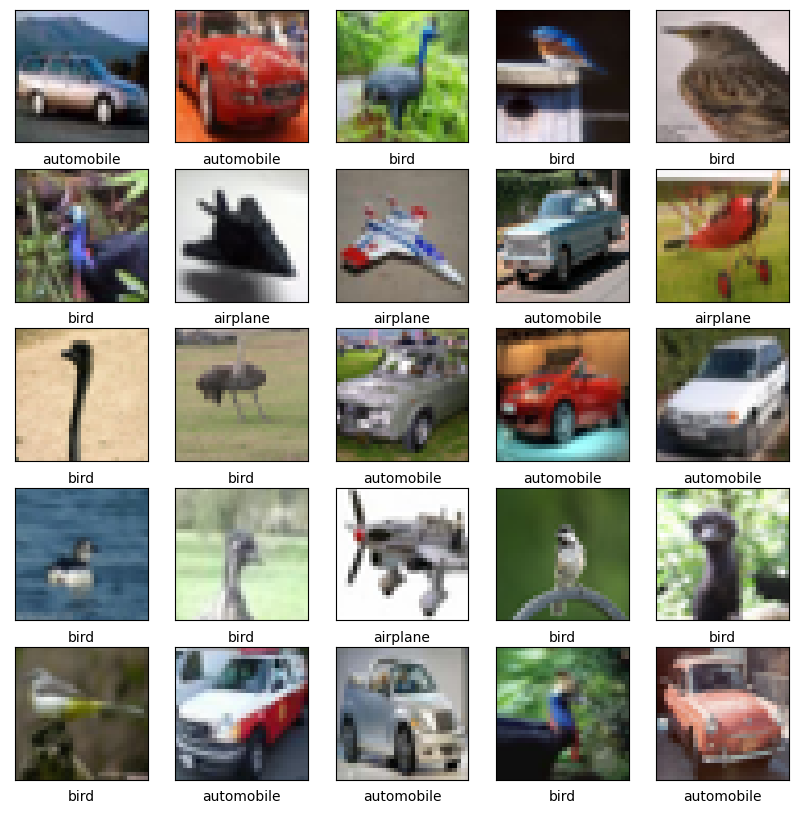

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# class_names = ['cat','dog']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create a CNN base network 

The first step in building a basic image classification model is to stack 2D convolutional layers with small dimensional kernels followed by pooling layers (max pooling or average pooling). These stacks or blocks form the feature extractor part of the model. Looking into the tensorflow documentation and examples is the best way to learn as you work on this problem. Start with looking into the tools that you imported.

Coming to some choices you would be making, you could experiment with the dimensions of the kernels in each layer, stride length of the filters, padding to be used, no. of filters in a layer. no. of convolutional layers in a block.   

Max pooling is generally favored in image classifiers as it performs dimensionality reduction while de-noising.

Padding is used on the convolutional layers to ensure the height and width of the output feature maps match the inputs. `Same` padding ensures that the size of the input matches with the size of the output after each convolutional layer by adding 0's to the borders of the images. `Valid` or no padding will see a decrease of size of output after each convolutional layer.

Convolutional and pooling layers form a block together for a simple base network and these blocks can be repeated where the number of filters in each block is varied with the varying depth of the network. Increasing the no. of filters with the depth of the network is a common practice with a big dataset like the one here. This ensures that the finer details of the images are learned. But you could experiment with paring down after a certain depth. 

 




### Question 2.1 - 8 points

In this question, we build the blocks that would be used to build the CNN part of a basic image classification model which would act as the *feature extractor* of the input images that discerns fine details like borders, shapes, distances etc. from an image.

-**2.1 a [4 points]** Complete the `input_block_basenet` function that acts as the first block of the model that takes in the input batch of images. The block should be composed of 2D convolutional layer/s followed by a pooling layer 

-**2.1 b [4 points]** Complete the `block_basenet` function to return blocks that increase the depth of the CNN model as we stack more blocks after the input block. The block should be composed of 2D convolutional layers followed by a pooling layer. This should be pretty similar to the 2.1 a bit, except that the input layer is not specified.

The stack of `input_block_basenet` followed by `block_basenet`s would build a feature extractor for a CNN image classifier. 

Note: All the parameters in the `input_block_basenet` and `block_basenet` functions are just suggestions you could totally build layers with different kernel dimensionality, strides, filters in a single block. Feel free to use all, any or none of the parameters. 

In [36]:
def input_block_basenet(model = Sequential(),n_filters = 32, conv_kernel_size = (3,3), strides = (1,1), pool_kernel_size = (2,2)):
    # You will build a basic block composed of a 
    # 2D convolutional layer/s followed by a pooling layer.
    # Take a look at how to use Sequential() function to stack layers and build a model
    # The first layer in this function should account for input dimensions
    block = model
    #BEGIN
    
    # create the first convolutional layer
    model.add(Conv2D(filters=n_filters, kernel_size=conv_kernel_size, strides=strides, padding='same', activation='relu', input_shape=(32, 32, 3)))

    # create the pooling layer
    model.add(MaxPooling2D(pool_size=pool_kernel_size))

    #END
    return block

def block_basenet(model = Sequential(),n_filters = 32, conv_kernel_size = (3,3), strides = (1,1), pool_kernel_size = (1,1)):
    # You will build a basic block composed of a 
    # 2D convolutional layer/s followed by a pooling layer.
    # Take a look at how to use Sequential() function to stack layers and build a model
    
    block = model
    #BEGIN

    # add a convolutional layer to the model
    model.add(Conv2D(filters=n_filters, kernel_size=conv_kernel_size, strides=strides, padding='same', activation='relu'))
    
    # add a pooling layer to the model
    model.add(MaxPooling2D(pool_size=pool_kernel_size))
    
    #END
    return block

### Question 2.2 - 4 points

In this question, we build the *classifier* part of the model that takes in the extracted features and outputs the probabilities of an image belonging to each class. The *classfier* would be composed of a `Flatten` layer to flatten the multi-dimensional output of the feature extractor, followed by `Dense` layer/s that act as a multi-layer perceptron. The last layer (output) should match the number of classes to extract the prediction and generally should not have an activation function as the loss is calculated based on the scores of the last layer to backpropogate with correct labels.

-**2.2 [4 points]** Complete the `classifier_basenet` function.

In [37]:
def classifier_basenet(model = Sequential()):
    # Workspace 2.2
    block = model
    #BEGIN
    
    # add a flatten layer to the model
    model.add(Flatten())

    # add a fully connected layer with 64 units and relu activation
    model.add(Dense(units=64, activation='relu'))
    
    # add another fully connected layer with 32 units and relu activation
    model.add(Dense(units=32, activation='relu'))
    
    # add a fully connected layer to the model 
    model.add(Dense(units=3, activation='softmax'))

    #END
    return block

### Question 2.3 and 2.4 - 8 points

-**2.3 [4 points]** In this question you will build the final basic model by combining all the layers you built in the previous questions.

-**2.4 [3 points + 1 point]** Compile the model by using an appropriate optimizer (checkout the documentation for tf.keras.optimizers), loss function (checkout the documentation for tf.keras.losses). Any accuracy above 89% gets full credit for this question.

In [38]:
# Workspace 2.3
#BEGIN

# initialize model
model = Sequential()

# 1 input layer 
model = input_block_basenet(model)

# 6 Convolutional blocks
model = block_basenet(model)
model = block_basenet(model)
model = block_basenet(model)
model = block_basenet(model)
model = block_basenet(model)
model = block_basenet(model)

# 2 dense layers and a classification head 
model = classifier_basenet(model)

#END

# Check the dimensional flow of the data through the network you built
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 32)     

In [41]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


No GPU found


In [40]:
# Workspace 2.4
#BEGIN

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# convert to onehot 
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

#END
history = model.fit(train_images, train_labels_one_hot, epochs=5, 
                    validation_data=(test_images,test_labels_one_hot))

Epoch 1/5
469/469 [==============================] - 22s 45ms/step - loss: 0.6456 - accuracy: 0.7228 - val_loss: 0.4704 - val_accuracy: 0.8180
Epoch 2/5
469/469 [==============================] - 22s 47ms/step - loss: 0.4178 - accuracy: 0.8328 - val_loss: 0.3597 - val_accuracy: 0.8597
Epoch 3/5
469/469 [==============================] - 21s 45ms/step - loss: 0.3499 - accuracy: 0.8636 - val_loss: 0.3189 - val_accuracy: 0.8733
Epoch 4/5
469/469 [==============================] - 22s 48ms/step - loss: 0.3102 - accuracy: 0.8813 - val_loss: 0.2901 - val_accuracy: 0.8857
Epoch 5/5
469/469 [==============================] - 22s 48ms/step - loss: 0.2632 - accuracy: 0.8977 - val_loss: 0.2759 - val_accuracy: 0.8927


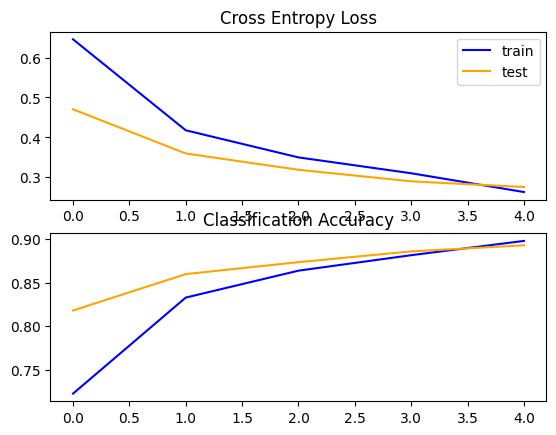

In [42]:
# Run this cell to visualize your training cycle
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
#     filename = sys.argv[0].split('/')[-1]
#     plt.savefig(filename + '_plot.png')
#     plt.close()

summarize_diagnostics(history)

### Question 2.5 - 10 points

-**2.5 a [8 points]** Iterate over n_filters in 2^n for n = [5,8] for the `block_basenet` function and make sure that you submit the notebook with the results and the training process in the outputs.

In [ ]:
n_filters = range(5,8)

# Workspace 2.5 a
#BEGIN

#END

### Workspace 2.5 b
**2.5 b [2 point]** What are your brief observations with the results? Where do you observe the best results?

% BEGIN

% END

### Question 2.6 - 10 points
-**2.6 a [8 points]** Iterate over kernel sizes from n = [1,6] and make sure that the results are shown in the output before you submit the notebook.

In [ ]:
kernel_dim = range(1,7)
# Workspace 2.6 a
#BEGIN

#END

### Workspace 2.6 b
**2.6 b [2 point]** What are your brief observations with the results? Where do you observe the best results?

% BEGIN

% END

### Question 2.7 - 10 points
-**2.7 a [8 points]** Iterate over stride size n = [1,3] and make sure that the results are shown in the output before you submit the notebook.

In [ ]:
stride_dim = range(1,3)

# Workspace 2.7 a
#BEGIN

#END

### Workspace 2.7 b
**2.7 b [2 points]** What are your brief observations with the results? Where do you observe the best results?

% BEGIN

% END